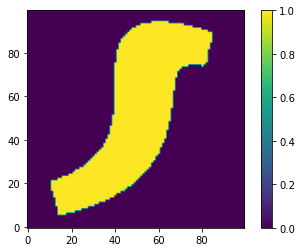

In [1]:
import torch
import numpy as np
from Packages.RegistrationFunc import *
from Packages.SplitEbinMetric import *
from Packages.GeoPlot import *
import scipy.io as sio
import matplotlib.pyplot as plt
import SimpleITK as sitk

g00 = sitk.GetArrayFromImage(sitk.ReadImage('Data/Cubic/cubic1_scaled_tensors.nhdr'))
g11 = sitk.GetArrayFromImage(sitk.ReadImage('Data/Cubic/cubic2_scaled_tensors.nhdr'))
g22 = sitk.GetArrayFromImage(sitk.ReadImage('Data/Cubic/cubic4_scaled_tensors.nhdr'))
g33 = sitk.GetArrayFromImage(sitk.ReadImage('Data/Cubic/cubic6_scaled_tensors.nhdr'))
gtt = sitk.GetArrayFromImage(sitk.ReadImage('Data/Cubic/cubic5_scaled_tensors.nhdr'))
mask0 = sitk.GetArrayFromImage(sitk.ReadImage('Data/Cubic/cubic1_filt_mask.nhdr'))
mask1 = sitk.GetArrayFromImage(sitk.ReadImage('Data/Cubic/cubic2_filt_mask.nhdr'))
mask2 = sitk.GetArrayFromImage(sitk.ReadImage('Data/Cubic/cubic4_filt_mask.nhdr'))
mask3 = sitk.GetArrayFromImage(sitk.ReadImage('Data/Cubic/cubic6_filt_mask.nhdr'))
mask = mask0 + mask1+mask2+mask3
mask[mask>0] = 1

fig = plt.figure()
im = plt.imshow(np.transpose(mask))
fig.colorbar(im)
plt.gca().invert_yaxis()
plt.show()

g00 = torch.from_numpy(g00).double()
g11 = torch.from_numpy(g11).double()
g22 = torch.from_numpy(g22).double()
g33 = torch.from_numpy(g33).double()
gtt = torch.from_numpy(gtt).double()
mask = torch.from_numpy(mask).double().permute(1,0)#.unsqueeze(0)
mask0 = torch.from_numpy(mask0).double().permute(1,0)
mask1 = torch.from_numpy(mask1).double().permute(1,0)
mask2 = torch.from_numpy(mask2).double().permute(1,0)
mask3 = torch.from_numpy(mask3).double().permute(1,0)
# mask = torch.ones((145,174))
g00 = g00.permute(2,1,0)
g11 = g11.permute(2,1,0)
g22 = g22.permute(2,1,0)
g33 = g33.permute(2,1,0)
gtt = gtt.permute(2,1,0)
# det = g11[0,:,:]*g11[2,:,:]-g11[1,:,:]*g11[1,:,:]
# weight = mask/det

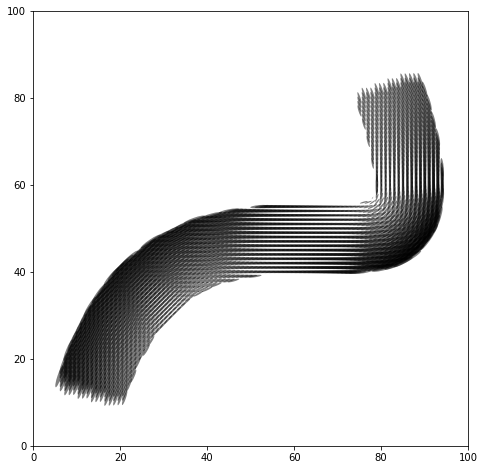

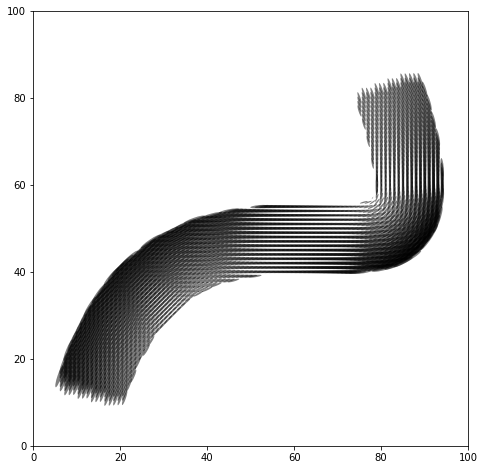

In [2]:
vis_tensors_kris(g00, title='', save_file=False, filename='', mask=None,scale=5e-1,opacity=0.5, show_axis_labels=True, ax=None,zorder=1,stride=None)

In [2]:
height, width = g00.shape[1], g00.shape[2]
g0m = torch.zeros(height,width,2,2,dtype=torch.double)
g1m = torch.zeros(height,width,2,2,dtype=torch.double)
g2m = torch.zeros(height,width,2,2,dtype=torch.double)
g3m = torch.zeros(height,width,2,2,dtype=torch.double)
gt = torch.zeros(height,width,2,2,dtype=torch.double)
g0m[:,:,0,0] = g00[0]
g0m[:,:,0,1] = g00[1]
g0m[:,:,1,0] = g00[1]
g0m[:,:,1,1] = g00[2]
g1m[:,:,0,0] = g11[0]
g1m[:,:,0,1] = g11[1]
g1m[:,:,1,0] = g11[1]
g1m[:,:,1,1] = g11[2]
g2m[:,:,0,0] = g22[0]
g2m[:,:,0,1] = g22[1]
g2m[:,:,1,0] = g22[1]
g2m[:,:,1,1] = g22[2]
g3m[:,:,0,0] = g33[0]
g3m[:,:,0,1] = g33[1]
g3m[:,:,1,0] = g33[1]
g3m[:,:,1,1] = g33[2]
gt[:,:,0,0] = gtt[0]
gt[:,:,0,1] = gtt[1]
gt[:,:,1,0] = gtt[1]
gt[:,:,1,1] = gtt[2]
g0m=torch.inverse(g0m)
g1m=torch.inverse(g1m)
g2m=torch.inverse(g2m)
g3m=torch.inverse(g3m)

In [3]:
# define the pullback action of phi
def phi_pullback(phi, g):
    idty = get_idty(*g.shape[-2:])
#     four layers of scalar field, of all 1, all 0, all 1, all 0, where the shape of each layer is g.shape[-2:]?
    d_phi = get_jacobian_matrix(phi - idty) + torch.einsum("ij,mn->ijmn", [torch.eye(2,dtype=torch.double),
                                                                           torch.ones(g.shape[-2:],dtype=torch.double)])
    g_phi = compose_function(g, phi)
#     matrix multiplication
# the last two dimension stays the same means point-wise multiplication, ijmn instead of jimn means the first d_phi need to be transposed
    return torch.einsum("ijmn,ikmn,klmn->jlmn",[d_phi, g_phi, d_phi])


# define the energy functional
def Energy(phi, g0, g1, f0, f1, sigma, lambd, mask): 

    '''
    compute the energy functional
    
    Parameters
    -----
    phi: the diffeomorphism
        size: 2 x N x N
        
    g0, g1: the initial and the target metrics
        size: 2 x 2 x N x N
        
    f0, f1: weighting tensors
        size: 2 x 2 x N x N
    
    sigma: the constant regularization parameter
    
    lambd: the weight that measures the change in the volumn density
    
    Returns
    -----
    The energy fuctional 
    
    ''' 
    phi_star_g1 = phi_pullback(phi, g1)
    phi_star_f1 = phi_pullback(phi, f1)
#     means d(g_0,\phi^*g_1)=d(\phi_*g_0,g_1), d(f_0,\phi^*f_1)=d(\phi_*f_0,f_1)?
    E1 = sigma*Squared_distance_Ebin(f0, phi_star_f1, lambd, mask)
    E2 = Squared_distance_Ebin(g0, phi_star_g1, lambd, mask)
    
    return E1 + E2


# define the energy functional
def Energy_L2(phi, g0, g1, f0, f1, sigma, weight): # 

    '''
    compute the energy functional
    
    Parameters
    -----
    phi: the diffeomorphism
        size: 2 x N x N
        
    g0, g1: the initial and the target metrics
        size: 2 x 2 x N x N
        
    f0, f1: weighting tensors
        size: 2 x 2 x N x N
    
    sigma: the constant regularization parameter
    
    lambd: the weight that measures the change in the volumn density
    
    Returns
    -----
    The energy fuctional 
    
    ''' 
    phi_star_g1 = phi_pullback(phi, g1)
    phi_star_f1 = phi_pullback(phi, f1)
    
#     E1 = sigma*torch.sum((f0 - phi_star_f1)**2)
#     E2 = torch.sum((g0 - phi_star_g1)**2)
    E1 = sigma*torch.einsum("...ij,kij->",[(f0 - phi_star_f1)**2, weight])
    E2 = torch.einsum("...ij,kij->",[(g0 - phi_star_g1)**2, weight])
    
    return E1 + E2

In [4]:
# # %matplotlib qt
# %matplotlib inline
# show_2d_tensors(g0m.permute(2,3,0,1), scale=0.5, title="g0", margin=0.05, dpi=20)
# show_2d_tensors(g1m.permute(2,3,0,1), scale=0.5, title="g1", margin=0.05, dpi=20)
# show_2d_tensors(g2m.permute(2,3,0,1), scale=0.5, title="g2", margin=0.05, dpi=20)
# show_2d_tensors(g3m.permute(2,3,0,1), scale=0.5, title="g3", margin=0.05, dpi=20)

In [5]:
# define the Laplacian inverse

def laplace_inverse(u):
    '''
    this function computes the laplacian inverse of a vector field u of size 2 x size_h x size_w 
    '''
    size_h, size_w = u.shape[-2:]
    shape = u.shape
    idty = get_idty(size_h, size_w).numpy()
    lap = 4. - 2.*(np.cos(2.*np.pi*idty[0]/size_w) + np.cos(2.*np.pi*idty[1]/size_h))
    lap[0,0] = 1.
    lapinv = 1./lap
    lap[0,0] = 0.
    lapinv[0,0] = 1.
    
    u = u.detach().numpy()
    fx = np.fft.fftn(u[0])
    fy = np.fft.fftn(u[1])
    fx *= lapinv
    fy *= lapinv
    vx = torch.from_numpy(np.real(np.fft.ifftn(fx)))
    vy = torch.from_numpy(np.real(np.fft.ifftn(fy)))
    
    return torch.stack((vx,vy))

In [6]:
def Vis_squared_distance_Ebin(g0, g1, a):  
    inv_g0 = get_inverse(g0)
    inv_g0_g1 = torch.einsum("ik...,kj...->...ij",[inv_g0, g1]) 
    trK0square = trKsquare(g0, g1) - torch.log(get_det(inv_g0_g1) + 1e-25)**2/2 
    theta = torch.min((trK0square/a + 1e-25).sqrt()/4, torch.tensor([np.pi],dtype=torch.double))
    
    det_g0 = g0[0, 0] * g0[1, 1] - g0[0, 1] * g0[1, 0] + 1e-25
    det_g1 = g1[0, 0] * g1[1, 1] - g1[0, 1] * g1[1, 0] + 1e-25
    
    alpha, beta = det_g0.pow(1/4), det_g1.pow(1/4)
    E = 16*a*(alpha**2 - 2*alpha*beta*torch.cos(theta) + beta**2)
    fig = plt.figure()
    im = plt.imshow(E)
    fig.colorbar(im)
    plt.gca().invert_yaxis()
    plt.show()
    return 0

In [7]:
def checkNaN(A):
    if (A != A).any():
        print('NaN')

In [8]:
def metric_matching(gi,gm,height,width,mask,Num_ite,epsilon,sigma):
    phi_inv = get_idty(height, width)
    phi = get_idty(height, width)
    idty = get_idty(height, width)
    idty.requires_grad_()
    f0 = torch.eye(2, dtype=torch.double).repeat(height, width,1,1).permute(2,3,0,1)
    f1 = torch.eye(2, dtype=torch.double).repeat(height, width,1,1).permute(2,3,0,1)
    det = gi[:,:,0, 0]*gi[:,:,1,1]-gi[:,:,0,1]*gi[:,:,1,0]
    
#     fig = plt.figure()
#     im = plt.imshow(det)
#     fig.colorbar(im)
#     plt.gca().invert_yaxis()
#     plt.show()
    
#     weight = mask/det#.unsqueeze(0)
    weight = mask#.unsqueeze(0)
#     print(mask.shape,det.shape)

    for j in range(Num_ite):
        phi_actsg0 = phi_pullback(phi_inv, gi.permute(2,3,0,1))
        phi_actsf0 = phi_pullback(phi_inv, f0)
        E = Energy(idty, phi_actsg0, gm.permute(2,3,0,1), phi_actsf0, f1, sigma,0.5, weight.unsqueeze(0)) 
#         print(E.item())
        E.backward()
        v = - laplace_inverse(idty.grad)
        with torch.no_grad():
            psi =  idty + epsilon*v  
            psi[0][psi[0]>width-1]=width-1
            psi[1][psi[1]>height-1]=height-1
            psi[psi<0]=0
            psi_inv =  idty - epsilon*v
            psi_inv[0][psi_inv[0]>width-1]=width-1
            psi_inv[1][psi_inv[1]>height-1]=height-1
            psi_inv[psi_inv<0]=0
            phi = compose_function(psi, phi)
            phi_inv = compose_function(phi_inv, psi_inv)
            idty.grad.data.zero_()
#         plot_diffeo(phi, step_size=2, show_axis=True)
    gi = phi_pullback(phi_inv, gi.permute(2,3,0,1)).permute(2,3,0,1)
    return gi, phi, phi_inv

In [9]:
def GetSITKImageFromNP(npimg, has_component_data=False):
  # If RGB or tensor data etc, set has_component_data to True so that last dimension is not
  # transposed.
  # This assumes that the component data is in the last dimension.
  # TODO fix this assumption to work for component data in first dimension as well
  # Currently works for 2D and 3D images
  if has_component_data:
    transpose_tuple=(1,0,2)
    if len(npimg.shape) == 4:
      transpose_tuple=(2,1,0,3)    
    return sitk.GetImageFromArray(np.transpose(npimg,transpose_tuple))
  else:
    transpose_tuple=(1,0)
    if len(npimg.shape) == 3:
      transpose_tuple=(2,1,0)           
    return sitk.GetImageFromArray(np.transpose(npimg, transpose_tuple))

## Main Process

In [10]:
# threshmask1 = torch.zeros_like(torch.det(g0m))
# threshmask1[torch.det(g0m)>5e7] = 1
# threshmask2 = torch.zeros_like(torch.det(g0m))
# threshmask2[torch.det(g0m)>1e7] = 1
# print(torch.norm(threshmask1-threshmask2))
# fig = plt.figure()
# im = plt.imshow(threshmask)#torch.det(g2m).detach().numpy()
# fig.colorbar(im)
# plt.gca().invert_yaxis()
# plt.show()


In [11]:
thresh_mask00 = torch.where(torch.det(g0m)>1e7,1/torch.det(g0m),5e-3)
thresh_mask11 = torch.where(torch.det(g1m)>1e7,1/torch.det(g1m),5e-3)
thresh_mask22 = torch.where(torch.det(g2m)>1e7,1/torch.det(g2m),5e-3)
thresh_mask33 = torch.where(torch.det(g3m)>1e7,1/torch.det(g3m),5e-3)
# print(torch.min(thresh_mask00),torch.min(thresh_mask22))
g0m=torch.einsum('ij...,kij->ij...',g0m,thresh_mask00.unsqueeze(0))
g1m=torch.einsum('ij...,kij->ij...',g1m,thresh_mask11.unsqueeze(0))
g2m=torch.einsum('ij...,kij->ij...',g2m,thresh_mask22.unsqueeze(0))
g3m=torch.einsum('ij...,kij->ij...',g3m,thresh_mask33.unsqueeze(0))

# show_2d_tensors(g0m.permute(2,3,0,1), scale=1e3, title="g0", margin=0.05, dpi=20)
# show_2d_tensors(g1m.permute(2,3,0,1), scale=1e3, title="g1", margin=0.05, dpi=20)
# show_2d_tensors(g2m.permute(2,3,0,1), scale=1e3, title="g2", margin=0.05, dpi=20)
# show_2d_tensors(g3m.permute(2,3,0,1), scale=1e3, title="g3", margin=0.05, dpi=20)

# fig = plt.figure()
# im = plt.imshow(torch.det(g0m))#torch.det(g2m).detach().numpy()
# fig.colorbar(im)
# plt.gca().invert_yaxis()
# plt.show()

In [12]:
E0m, E1m, E2m, E3m=[],[],[],[]
phi_inv0_final = get_idty(height, width)
phi0_final = get_idty(height, width)
phi_inv1_final = get_idty(height, width)
phi1_final = get_idty(height, width)
phi_inv2_final = get_idty(height, width)
phi2_final = get_idty(height, width)
phi_inv3_final = get_idty(height, width)
phi3_final = get_idty(height, width)
for i in range(201):
    G = torch.stack((g0m,g1m,g2m,g3m))
    a = 0.5
    gm = get_KarcherMean(G, a)
    E0m.append(torch.einsum("ij...,kij->",[(g0m - gm)**2, mask.unsqueeze(0)]).item())
    E1m.append(torch.einsum("ij...,kij->",[(g1m - gm)**2, mask.unsqueeze(0)]).item())
    E2m.append(torch.einsum("ij...,kij->",[(g2m - gm)**2, mask.unsqueeze(0)]).item())
    E3m.append(torch.einsum("ij...,kij->",[(g3m - gm)**2, mask.unsqueeze(0)]).item())
    if i%10 ==0:
        print(i)
        gmm = np.zeros((height,width,3))
        gmm[:,:,0]=gm[:,:,0,0]
        gmm[:,:,1]=gm[:,:,0,1]
        gmm[:,:,2]=gm[:,:,1,1]
#         sitk.WriteImage(GetSITKImageFromNP(gmm, has_component_data=True), 'InvCubic1246TemplateEbin/cubic_'+str(i)+'_scaled_tensors.nhdr')
#         plot_diffeo(phi_inv0_final, step_size=2, show_axis=True)
#         plot_diffeo(phi_inv1_final, step_size=2, show_axis=True)
#         plot_diffeo(phi_inv2_final, step_size=2, show_axis=True)
#         plot_diffeo(phi_inv3_final, step_size=2, show_axis=True)
#         sio.savemat('InvCubic3467TemplateEbin/Cubic3_'+str(i)+'_phi_inv_ebin.mat', {'diffeo': phi_inv0_final.detach().numpy()})
#         sio.savemat('InvCubic3467TemplateEbin/Cubic3_'+str(i)+'_phi_ebin.mat', {'diffeo': phi0_final.detach().numpy()})
#         sio.savemat('InvCubic3467TemplateEbin/Cubic4_'+str(i)+'_phi_inv_ebin.mat', {'diffeo': phi_inv1_final.detach().numpy()})
#         sio.savemat('InvCubic3467TemplateEbin/Cubic4_'+str(i)+'_phi_ebin.mat', {'diffeo': phi1_final.detach().numpy()})
#         sio.savemat('InvCubic3467TemplateEbin/Cubic6_'+str(i)+'_phi_inv_ebin.mat', {'diffeo': phi_inv2_final.detach().numpy()})
#         sio.savemat('InvCubic3467TemplateEbin/Cubic6_'+str(i)+'_phi_ebin.mat', {'diffeo': phi2_final.detach().numpy()})
#         sio.savemat('InvCubic3467TemplateEbin/Cubic7_'+str(i)+'_phi_inv_ebin.mat', {'diffeo': phi_inv3_final.detach().numpy()})
#         sio.savemat('InvCubic3467TemplateEbin/Cubic7_'+str(i)+'_phi_ebin.mat', {'diffeo': phi3_final.detach().numpy()})
#         show_2d_tensors(gm.permute(2,3,0,1), scale=0.5, title="gm", margin=0.05, dpi=20)
#         show_2d_tensors(gt.permute(2,3,0,1), scale=0.5, title="gt", margin=0.05, dpi=20)
#         show_2d_tensors(gt.permute(2,3,0,1), scale=0.5, title="gtarget", margin=0.05, dpi=20)
#         Vis_squared_distance_Ebin(gm.permute(2,3,0,1), gt.permute(2,3,0,1), 0.5)
#         print(Squared_distance_Ebin(gm.permute(2,3,0,1), gt.permute(2,3,0,1), a, mask).numpy())
    lambd = 0.5
    sigma = 0
#     epsilon = 5e-7
    epsilon = 5e0
    Num_ite = 1
    
    g0m,phi0,phi_inv0 = metric_matching(g0m,gm,height,width,mask,Num_ite,epsilon,sigma)
    g1m,phi1,phi_inv1 = metric_matching(g1m,gm,height,width,mask,Num_ite,epsilon,sigma)
    g2m,phi2,phi_inv2 = metric_matching(g2m,gm,height,width,mask,Num_ite,epsilon,sigma)
    g3m,phi3,phi_inv3 = metric_matching(g3m,gm,height,width,mask,Num_ite,epsilon,sigma)
    
#     phi_inv0_final = compose_function(phi_inv0, phi_inv0_final)
    phi_inv0_final = compose_function(phi_inv0_final, phi_inv0)
    phi0_final = compose_function(phi0, phi0_final)
    mask0 = compose_function(mask0, phi_inv0)
#     phi_inv1_final = compose_function(phi_inv1, phi_inv1_final)
    phi_inv1_final = compose_function(phi_inv1_final, phi_inv1)
    phi1_final = compose_function(phi1, phi1_final)
    mask1 = compose_function(mask1, phi_inv1)
#     phi_inv2_final = compose_function(phi_inv2, phi_inv2_final)
    phi_inv2_final = compose_function(phi_inv2_final, phi_inv2)
    phi2_final = compose_function(phi2, phi2_final)
    mask2 = compose_function(mask2, phi_inv2)
#     phi_inv3_final = compose_function(phi_inv3, phi_inv3_final)
    phi_inv3_final = compose_function(phi_inv3_final, phi_inv3)
    phi3_final = compose_function(phi3, phi3_final)
    mask3 = compose_function(mask3, phi_inv3)
    

/home/sci/hdai/IPMIbugfree/Packages/SplitEbinMetric.py:371: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729006826/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  Ind_inRange = (theta < 0).nonzero().reshape(-1)  ## G[i] is in the range of the exponential map at gm


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200


In [13]:
Vis_squared_distance_Ebin(gm.permute(2,3,0,1), gt.permute(2,3,0,1), 0.5)

NameError: name 'get_inverse' is not defined

In [ ]:
# sio.savemat('InvCubic6734TemplateEbin/E_103818_m_ebin.mat', {'energy': E_103818_m})
# sio.savemat('InvCubic6734TemplateEbin/E_111312_m_ebin.mat', {'energy': E_111312_m})

In [ ]:
plt.plot(E0m)
plt.plot(E1m)
plt.plot(E2m)
plt.plot(E3m)

In [ ]:
plt.plot(np.array(E0m)+np.array(E1m)+np.array(E2m)+np.array(E3m))

In [ ]:
fig = plt.figure()
im = plt.imshow(mask0+mask1+mask2+mask3)#torch.det(g2m).detach().numpy()
fig.colorbar(im)
plt.gca().invert_yaxis()
plt.show()

In [ ]:
mask = mask0+mask1+mask2+mask3
# sio.savemat('InvCubic1246TemplateEbin/mask.mat', {'mask': mask.detach().numpy()})
# sitk.WriteImage(GetSITKImageFromNP(gmm, has_component_data=True), 'InvCubic1246TemplateEbin1k/cubic_1k_scaled_tensors.nhdr')

In [ ]:
# g0m[:,:,0,0] = g00[0]
# g0m[:,:,0,1] = g00[1]
# g0m[:,:,1,0] = g00[1]
# g0m[:,:,1,1] = g00[2]
# g1m[:,:,0,0] = g11[0]
# g1m[:,:,0,1] = g11[1]
# g1m[:,:,1,0] = g11[1]
# g1m[:,:,1,1] = g11[2]
# g2m[:,:,0,0] = g22[0]
# g2m[:,:,0,1] = g22[1]
# g2m[:,:,1,0] = g22[1]
# g2m[:,:,1,1] = g22[2]
# g3m[:,:,0,0] = g33[0]
# g3m[:,:,0,1] = g33[1]
# g3m[:,:,1,0] = g33[1]
# g3m[:,:,1,1] = g33[2]
# gt[:,:,0,0] = gtt[0]
# gt[:,:,0,1] = gtt[1]
# gt[:,:,1,0] = gtt[1]
# gt[:,:,1,1] = gtt[2]
# phi_actsg0 = phi_pullback(phi_inv0_final, g0m.permute(2,3,0,1))
# phi_actsg1 = phi_pullback(phi_inv1_final, g1m.permute(2,3,0,1))
# phi_actsg2 = phi_pullback(phi_inv2_final, g2m.permute(2,3,0,1))
# phi_actsg3 = phi_pullback(phi_inv3_final, g3m.permute(2,3,0,1))

In [14]:
gmm[:,:,0]=gm[:,:,0,0]
gmm[:,:,1]=gm[:,:,0,1]
gmm[:,:,2]=gm[:,:,1,1]
sitk.WriteImage(GetSITKImageFromNP(gmm, has_component_data=True), 'orig_result.nhdr')
# sio.savemat('InvCubic1246TemplateEbin/Cubic1_noweight_phi_inv_ebin.mat', {'diffeo': phi_inv0_final.detach().numpy()})
# sio.savemat('InvCubic1246TemplateEbin/Cubic1_noweight_phi_ebin.mat', {'diffeo': phi0_final.detach().numpy()})
# sio.savemat('InvCubic1246TemplateEbin/Cubic2_noweight_phi_inv_ebin.mat', {'diffeo': phi_inv1_final.detach().numpy()})
# sio.savemat('InvCubic1246TemplateEbin/Cubic2_noweight_phi_ebin.mat', {'diffeo': phi1_final.detach().numpy()})
# sio.savemat('InvCubic1246TemplateEbin/Cubic4_noweight_phi_inv_ebin.mat', {'diffeo': phi_inv2_final.detach().numpy()})
# sio.savemat('InvCubic1246TemplateEbin/Cubic4_noweight_phi_ebin.mat', {'diffeo': phi2_final.detach().numpy()})
# sio.savemat('InvCubic1246TemplateEbin/Cubic6_noweight_phi_inv_ebin.mat', {'diffeo': phi_inv3_final.detach().numpy()})
# sio.savemat('InvCubic1246TemplateEbin/Cubic6_noweight_phi_ebin.mat', {'diffeo': phi3_final.detach().numpy()})
# sitk.WriteImage(GetSITKImageFromNP(gmm, has_component_data=True), 'InvCubic1246TemplateEbin/cubic_noweight_scaled_tensors.nhdr')
# show_2d_tensors(phi_actsg1, scale=1e-3, title="g1", margin=0.05, dpi=20)
# show_2d_tensors(phi_actsg2, scale=1e-3, title="g2", margin=0.05, dpi=20)
# show_2d_tensors(phi_actsg3, scale=1e-3, title="g3", margin=0.05, dpi=20)

### Save template

In [ ]:
# def GetSITKImageFromNP(npimg, has_component_data=False):
#   # If RGB or tensor data etc, set has_component_data to True so that last dimension is not
#   # transposed.
#   # This assumes that the component data is in the last dimension.
#   # TODO fix this assumption to work for component data in first dimension as well
#   # Currently works for 2D and 3D images
#   if has_component_data:
#     transpose_tuple=(1,0,2)
#     if len(npimg.shape) == 4:
#       transpose_tuple=(2,1,0,3)    
#     return sitk.GetImageFromArray(np.transpose(npimg,transpose_tuple))
#   else:
#     transpose_tuple=(1,0)
#     if len(npimg.shape) == 3:
#       transpose_tuple=(2,1,0)           
#     return sitk.GetImageFromArray(np.transpose(npimg, transpose_tuple))

# gmm = np.zeros((height,width,3))
# gmm[:,:,0]=gm[:,:,0,0]
# gmm[:,:,1]=gm[:,:,0,1]
# gmm[:,:,2]=gm[:,:,1,1]
# sitk.WriteImage(GetSITKImageFromNP(gmm, has_component_data=True), 'Data/Cubic/cubic4_6_scaled_latesttemplate_tensors.nhdr')

In [ ]:
# phi = torch.from_numpy(sio.loadmat('InvCubic1246TemplateEbin/Cubic1_noweight_phi_ebin.mat')['diffeo']).double()
# phi_inv = torch.from_numpy(sio.loadmat('InvCubic1246TemplateEbin/Cubic1_noweight_phi_inv_ebin.mat')['diffeo']).double()
idty = compose_function(phi_inv3_final, phi3_final)
plot_diffeo(idty, step_size=2, show_axis=True)